# Construction of FFNN based on normalized training space
Upon stabilization and convergence of the model training loss curve to a non small number, normalization becomes imperative to homogenize the training space. Here, the training procedure is reiterated on a normalized training space employing two methods, namely min-max and Z-score normalization. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import save_model
from pathlib import Path

making home directory if it doesn't exist

In [2]:
home_dir = Path().home()
ml_data = home_dir / 'ml_data'
if not ml_data.exists():
    ml_data.mkdir()

## Loading the training space and normalizing 


Loading data which is already generated:

In [3]:
Design_space = np.load(ml_data / 'Design_space2.npy')
moment_capacity = np.load(ml_data / 'Mu2.npy')

Normalization of input data for training a neural network is a crucial preprocessing step that ensures stable and efficient training. It involves scaling the input features to a similar range, typically between 0 and 1 or with zero mean and unit variance. This helps prevent certain features from dominating the learning process and can accelerate convergence during training. Here's how we can normalize input data for training the neural network using min-max normalization and Z-score normalization:
1. Min-Max Normalization: Min-max normalization scales the input features to a fixed range, typically between 0 and 1.
$$
x_{\text {norm }}=\frac{x-\min (x)}{\max (x)-\min (x)}
$$


In [4]:
# Min-Max Normalization
Design_space_normalized_min_max = (Design_space - np.min(Design_space, axis=0)) / (np.max(Design_space, axis=0) - np.min(Design_space, axis=0))
moment_capacity_normalized_min_max = (moment_capacity - np.min(moment_capacity, axis=0)) / (np.max(moment_capacity, axis=0) - np.min(moment_capacity, axis=0))

2. Z-score Normalization: Z-score normalization (also known as standardization) scales the input features to have a mean of 0 and a standard deviation of 1 .
$$
x_{\text {norm }}=\frac{x-\operatorname{mean}(x)}{\operatorname{std}(x)}
$$

In [5]:
# Z-score Normalization:
Design_space_normalized_z_score = (Design_space - np.mean(Design_space, axis=0)) / np.std(Design_space, axis=0)
moment_capacity_normalized_z_score = (moment_capacity - np.mean(moment_capacity, axis=0)) / np.std(moment_capacity, axis=0)

## Visualization of the admissible design space for defined moment capacity

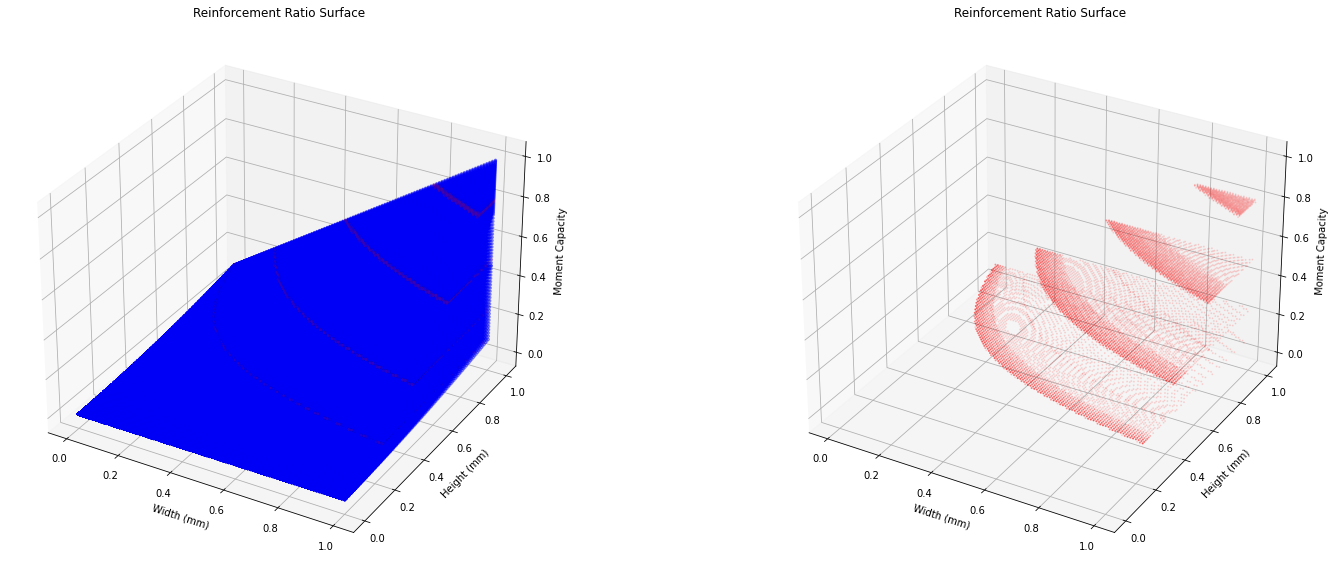

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.set_xlabel('Width (mm)')
ax1.set_ylabel('Height (mm)')
ax1.set_zlabel('Moment Capacity')
ax1.set_title('Reinforcement Ratio Surface')
ax2.set_xlabel('Width (mm)')
ax2.set_ylabel('Height (mm)')
ax2.set_zlabel('Moment Capacity')
ax2.set_title('Reinforcement Ratio Surface')

def plot_points_within_tolerance(Design_space_normalized_min_max, moment_capacity_normalized_min_max, target_z_value, tolerance, step_reinforcement, ax1, ax2):
    index=0
    for i in np.unique(Design_space_normalized_min_max[:, 0])[::step_reinforcement]:
        subset = Design_space_normalized_min_max[Design_space_normalized_min_max[:, 0] == i]
        z_values = np.array(moment_capacity_normalized_min_max[Design_space_normalized_min_max[:, 0] == i])
        for target_z_value in target_z_values:
            within_tolerance = np.isclose(z_values, target_z_value, rtol=tolerance)
            colors = ['red' if val else 'blue' for val in within_tolerance]
            red_indices = np.where(within_tolerance)[0]  # Get indices of red points
            # ax1 plots whole design space including inadmissible design space in blue and admissible in red
            ax1.scatter(subset[:, 1], subset[:, 2], z_values, label=f"Set {int(i)}", color=colors, alpha=0.1, s=5)
            # ax2 plots only the admissible design space linked by defined moment capacity in red
            ax2.scatter(subset[red_indices, 1], subset[red_indices, 2], z_values[red_indices], label=f"Set {int(i)}", color='red', alpha=0.1, s=1)
        # index += 1
        # if index == 50:
        #     break
target_z_values = [0.1, 0.25, 0.5, 0.8]
tolerance = 0.01
plot_step_for_reinforcement_ratio = 1


plot_points_within_tolerance(Design_space_normalized_min_max, moment_capacity_normalized_min_max, target_z_values, tolerance, plot_step_for_reinforcement_ratio, ax1, ax2)

plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import numpy as np


X = Design_space_normalized_min_max
y = moment_capacity_normalized_min_max

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [7]:
# Desired moment capacity value and tolerance
desired_moment_capacity = 0.5
tolerance = 0.01

num_samples = 10000
samples = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(num_samples, X.shape[1]))

predicted_moment_capacities = model.predict(samples)

admissible_inputs = samples[(predicted_moment_capacities >= desired_moment_capacity * (1 - tolerance)) &
                            (predicted_moment_capacities <= desired_moment_capacity * (1 + tolerance))]

print(f'Number of admissible inputs: {len(admissible_inputs)}')


Number of admissible inputs: 29


Admissible input: [0.80673828 0.57093285 0.91810494], Predicted moment capacity: 0.49511356865710615
Admissible input: [0.6325345  0.81486596 0.82112953], Predicted moment capacity: 0.5003500719329874
Admissible input: [0.423919   0.80719821 0.88774185], Predicted moment capacity: 0.49717995359643935
Admissible input: [0.90681589 0.65516977 0.84981152], Predicted moment capacity: 0.4992246639321726
Admissible input: [0.29626455 0.9362908  0.97744509], Predicted moment capacity: 0.501735503596024
Admissible input: [0.91553829 0.75799805 0.7927856 ], Predicted moment capacity: 0.49758269932284044
Admissible input: [0.69345563 0.90415294 0.75362241], Predicted moment capacity: 0.49578970635130654
Admissible input: [0.84795889 0.69643795 0.83450388], Predicted moment capacity: 0.5023303212795492
Admissible input: [0.44226909 0.89652991 0.84337292], Predicted moment capacity: 0.5020119492433741
Admissible input: [0.9354422  0.74368018 0.79676039], Predicted moment capacity: 0.50492417928651

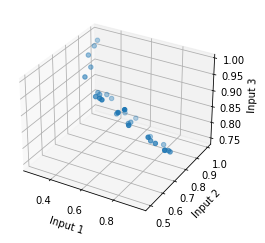

In [15]:
import matplotlib.pyplot as plt

# Validate admissible inputs by predicting moment capacities
validated_outputs = model.predict(admissible_inputs)

# Print some examples of admissible inputs and their corresponding moment capacities
for i in range(min(10, len(admissible_inputs))):
    print(f'Admissible input: {admissible_inputs[i]}, Predicted moment capacity: {validated_outputs[i]}')

# Visualize the admissible inputs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(admissible_inputs[:, 0], admissible_inputs[:, 1], admissible_inputs[:, 2])
ax.set_xlabel('Input 1')
ax.set_ylabel('Input 2')
ax.set_zlabel('Input 3')
plt.show()
